In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os

In [ ]:
# ---- 1. Load the file ----
file_path = "dtd_predictions.npy"
#file_path = "dtd_predictions_own.npy" 

print("Loading file...")
data = np.load(file_path, allow_pickle=True)
print("Loaded. Type:", type(data))

# ---- 2. Inspect basic info ----
print("Shape:", data.shape)
print("Dtype:", data.dtype)

Loading file...
Loaded. Type: <class 'numpy.ndarray'>
Shape: (5886, 192, 320)
Dtype: float32


In [38]:
# If it's a list or contains multiple maps
if isinstance(data, (list, tuple)):
    print("First element type:", type(data[0]))
    print("First element shape:", np.array(data[0]).shape)
    
os.makedirs("dtd_outputs", exist_ok=True)

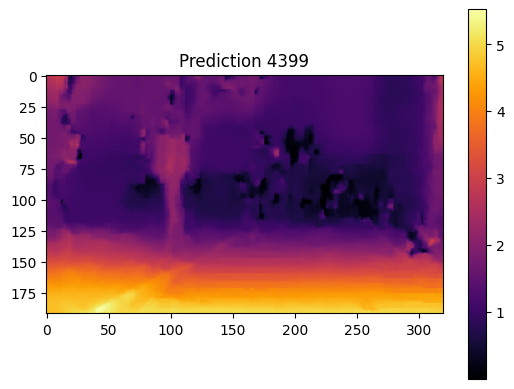

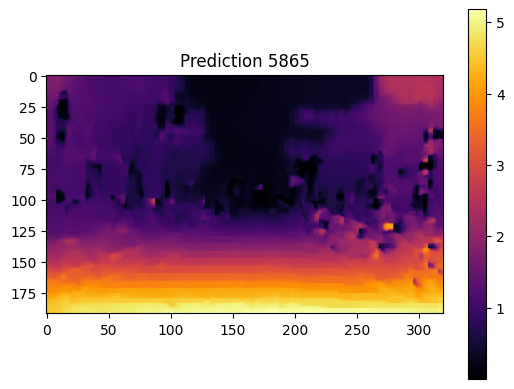

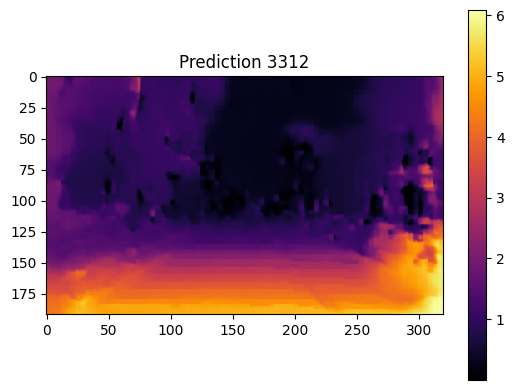

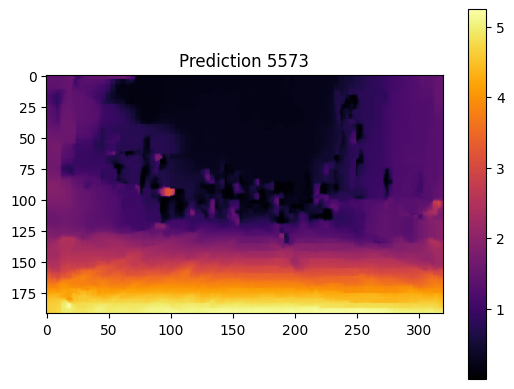

In [39]:
for i in np.random.choice(len(data), 4, replace=False):  # show random 5 results
    plt.figure()
    plt.imshow(data[i], cmap='inferno')
    plt.title(f"Prediction {i}")
    plt.colorbar()
    plt.show()
    
    disp = data[i]
    
    # Correct normalization
    disp_norm = (disp - disp.min()) / (disp.max() - disp.min()) * 255
    disp_norm = disp_norm.astype(np.uint8)
    
    # Save normalized image
    cv2.imwrite(f"dtd_outputs/disp_{i}.png", disp_norm)


# DTD Dataset

In [ ]:
# ---------------------------------------
# Paths
# ---------------------------------------
number_file = "datasets/robotcar/files/2014-12-16-18-44-24_numbered.txt"
image_dir = "datasets/robotcar/2014-12-16-18-44-24/stereo/left"

predictions = data  # your loaded npy predictions

# ---------------------------------------
# Load numbered timestamp mappings
# Format: index timestamp 5
# ---------------------------------------
img_ids = []

with open(number_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        idx = parts[0]                   # column 1
        timestamp = parts[1]             # column 2
        img_ids.append(timestamp)
# ---------------------------------------
# Loop over random 5 predictions
# ---------------------------------------
for i in np.random.choice(len(predictions), 5, replace=False):

    # ---- 1. Get timestamp from the list ----
    timestamp = img_ids[i]

    # ---- 2. Build image path ----
    img_path = f"{image_dir}/{timestamp}.png"

    # ---- 3. Load the image ----
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ---- 4. Get disparity prediction ----
    disp = predictions[i]
    disp_norm = (disp - disp.min()) / (disp.max() - disp.min()) * 255
    disp_norm = disp_norm.astype(np.uint8)

    # ---- 5. Display ----
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image {timestamp}")

    plt.subplot(1,2,2)
    plt.imshow(disp_norm, cmap='inferno')
    plt.title(f"Disparity {i}")

    plt.savefig(f"dtd_outputs/pred_{i}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    




IndexError: list index out of range

 python dtd\test.py --test_file_path dtd\test_kitti.txt --checkpoint_path dtd\dtd_depth_net_20.pth --save_dir dtd\test

# KITTI Dataset

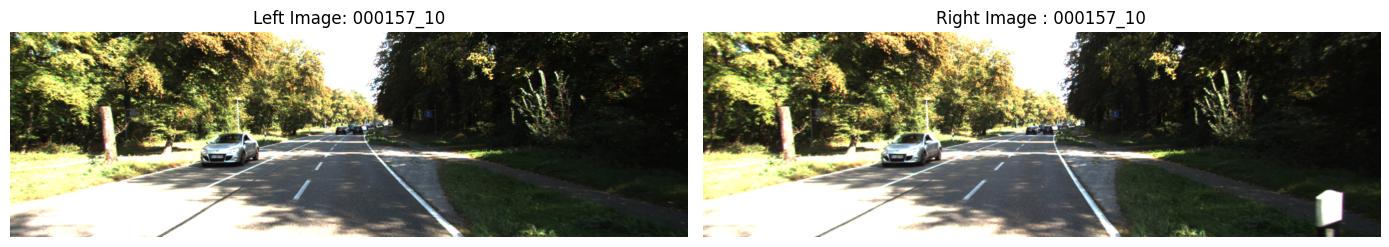

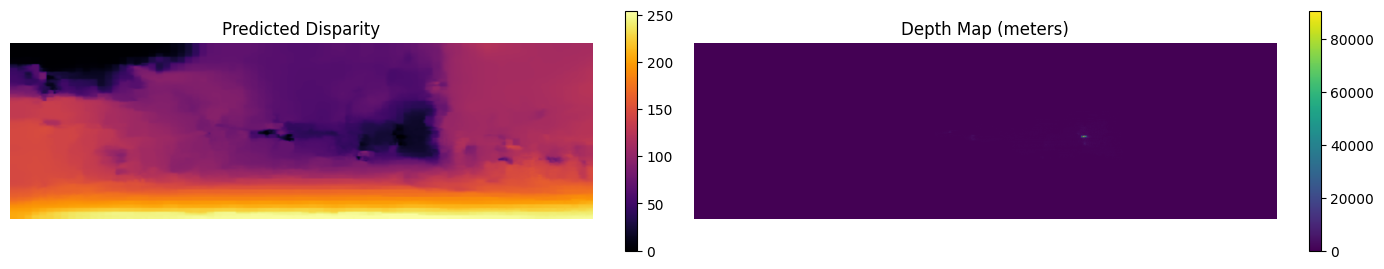

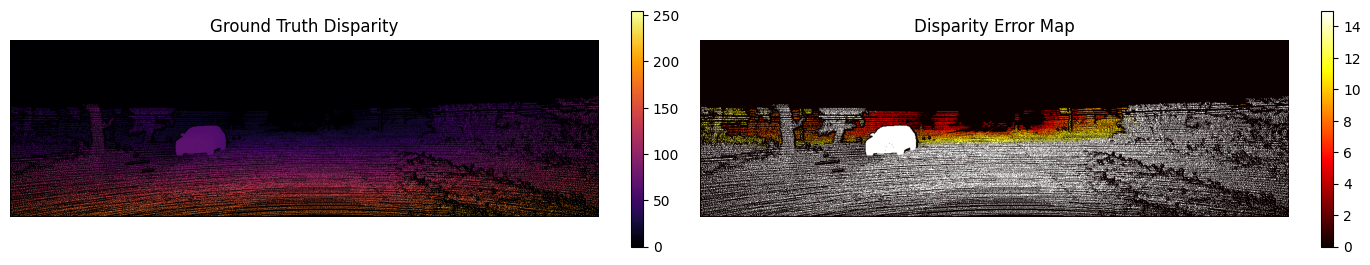

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# SELECT KITTI SAMPLE
# ==========================================================
image_id = "000157_10"    # change if needed

left_path = f"../datasets/data_scene_flow/training/image_2/{image_id}.png"
right_path = f"../datasets/data_scene_flow/training/image_3/{image_id}.png"
gt_path   = f"../datasets/data_scene_flow/training/disp_occ_0/{image_id}.png"

# Your prediction:
pred = predictions[4]   # ensure correct index

# ==========================================================
# LOAD IMAGES
# ==========================================================
left_img  = cv2.imread(left_path,  cv2.IMREAD_COLOR)
right_img = cv2.imread(right_path, cv2.IMREAD_COLOR)
left_img  = cv2.cvtColor(left_img,  cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

# ==========================================================
# LOAD GROUND TRUTH DISPARITY
# ==========================================================
gt_disp = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 256.0

# Match prediction shape to GT
if pred.shape != gt_disp.shape:
    pred = cv2.resize(pred, (gt_disp.shape[1], gt_disp.shape[0]), interpolation=cv2.INTER_LINEAR)

mask = gt_disp > 0

# ==========================================================
# ERROR MAP
# ==========================================================
error_map = np.zeros_like(gt_disp)
error_map[mask] = np.abs(pred[mask] - gt_disp[mask])

# ==========================================================
# DEPTH MAP (Z = fB / disparity)
# ==========================================================
f = 721.0
B = 0.54
depth = np.zeros_like(pred)
depth[mask] = (f * B) / (pred[mask] + 1e-6)

# ==========================================================
# NORMALIZED VISUALIZATION MAPS
# ==========================================================
pred_vis = ((pred - pred.min()) / (pred.max() - pred.min() + 1e-6) * 255).astype(np.uint8)
gt_vis   = ((gt_disp - gt_disp.min()) / (gt_disp.max() - gt_disp.min() + 1e-6) * 255).astype(np.uint8)

# ==========================================================
# FIGURE A — Left + Right Image
# ==========================================================
plt.figure(figsize=(14,2.8))

plt.subplot(1,2,1)
plt.imshow(left_img)
plt.title(f"Left Image: {image_id}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(right_img)
plt.title(f"Right Image : {image_id}")
plt.axis('off')

plt.tight_layout()
plt.show()

# ==========================================================
# FIGURE B — Disparity + Depth
# ==========================================================
plt.figure(figsize=(14,2.8))

plt.subplot(1,2,1)
im1 = plt.imshow(pred_vis, cmap='inferno')
plt.title("Predicted Disparity")
plt.axis('off')
plt.colorbar(im1, fraction=0.046)

plt.subplot(1,2,2)
im2 = plt.imshow(depth, cmap='viridis')
plt.title("Depth Map (meters)")
plt.axis('off')
plt.colorbar(im2, fraction=0.046)

plt.tight_layout()
plt.show()

# ==========================================================
# FIGURE C — Ground Truth + Error Map
# ==========================================================
plt.figure(figsize=(14,2.8))

plt.subplot(1,2,1)
im1 = plt.imshow(gt_vis, cmap='inferno')
plt.title("Ground Truth Disparity")
plt.axis('off')
plt.colorbar(im1, fraction=0.046)

plt.subplot(1,2,2)
im2 = plt.imshow(error_map, cmap='hot', vmax=15)
plt.title("Disparity Error Map")
plt.axis('off')
plt.colorbar(im2, fraction=0.046)

plt.tight_layout()
plt.show()
